In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import random

In [13]:
def get_scores(df: pd.DataFrame, step: float, end: float, start: float, drop_cols: list, unique_images, n_jobs) -> list:
    scores = {}
    last_n_images = None
    for perc in np.arange(start, end, step):
        sample_size = int(len(unique_images) * perc)
        if sample_size == 0:
            scores[perc] = [np.nan, 0]
            continue
        if sample_size == last_n_images:
            scores[perc] = [np.nan, last_n_images]  # Skip if same as previous
            continue
        last_n_images = sample_size
        selected_images = random.sample(list(unique_images), sample_size)
        df_train = df[df['sample_id'].isin(selected_images)].drop(columns=drop_cols)
        
        X_train = df_train.drop(columns=['cell_type'])
        y_train = df_train['cell_type']
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(y_train)

        xgb = XGBClassifier(objective='multi:softmax', n_jobs=n_jobs)
        xgb.fit(X_train, y_train)

        true = df['cell_type']
        df_predict = df.drop(columns=drop_cols + ['cell_type'])
        pred = xgb.predict(df_predict)
        pred = label_encoder.inverse_transform(pred)
        score = f1_score(pred, true, average='macro')
        scores[perc] = [score, sample_size]
    del df_train, X_train, y_train, df_predict, pred, true, xgb
    return scores


In [15]:
df_score = pd.DataFrame(index=np.arange(0.01, 0.51, 0.01) * 100, columns=['n_images_IMMUcan','n_images_cHL_2_MIBI', 'perc_images_IMMUcan', 'perc_images_cHL_2_MIBI', 'f1_score_IMMUcan', 'f1_score_cHL_2_MIBI'])

In [14]:
df_immu = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/IMMUcan_quantification.csv')
unique_images_immu = df_immu['sample_id'].unique()
scores = get_scores(df_immu, 0.01, 0.51, 0.01, 
                    ['image', 'sample_id', 'cell_id', 'x', 'y', 'width_px',
                     'height_px', 'cell_labels', 'level_1_cell_type', 'level_2_cell_type'], 
                    unique_images_immu, 6)

In [16]:
df_score['f1_score_IMMUcan'] = [first for first, _ in scores.values()]
df_score['n_images_IMMUcan'] = [second for _, second in scores.values()]
df_score['perc_images_IMMUcan'] = df_score['n_images_IMMUcan'] / df_immu['sample_id'].nunique()
df_score

,n_images_IMMUcan,n_images_cHL_2_MIBI,perc_images_IMMUcan,perc_images_cHL_2_MIBI,f1_score_IMMUcan,f1_score_cHL_2_MIBI
1.0,1,NaN,0.005587,NaN,0.448111,NaN
2.0,3,NaN,0.016760,NaN,0.769857,NaN
3.0,5,NaN,0.027933,NaN,0.723259,NaN
4.0,7,NaN,0.039106,NaN,0.842145,NaN
5.0,8,NaN,0.044693,NaN,0.834430,NaN
6.0,10,NaN,0.055866,NaN,0.858239,NaN
7.0,12,NaN,0.067039,NaN,0.874196,NaN
8.0,14,NaN,0.078212,NaN,0.880628,NaN
9.0,16,NaN,0.089385,NaN,0.892827,NaN
10.0,17,NaN,0.094972,NaN,0.876695,NaN


In [18]:
df_cHL_2 = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/datasets/cHL_2_MIBI_quantification.csv')
unique_images_cHL_2 = df_cHL_2['sample_id'].unique()
scores_cHL_2 = get_scores(df_cHL_2, 0.01, 0.51, 0.01, 
                    ['sample_id', 'cell_id', 'x', 'y', 'level_1_cell_type', 'level_2_cell_type'], 
                    unique_images_cHL_2, n_jobs=6)

In [19]:
df_score['f1_score_cHL_2_MIBI'] = [first for first, _ in scores_cHL_2.values()]
df_score['n_images_cHL_2_MIBI'] = [second for _, second in scores_cHL_2.values()]
df_score['perc_images_cHL_2_MIBI'] = df_score['n_images_cHL_2_MIBI'] / df_cHL_2['sample_id'].nunique()
df_score

,n_images_IMMUcan,n_images_cHL_2_MIBI,perc_images_IMMUcan,perc_images_cHL_2_MIBI,f1_score_IMMUcan,f1_score_cHL_2_MIBI
1.0,1,0,0.005587,0.000000,0.448111,NaN
2.0,3,0,0.016760,0.000000,0.769857,NaN
3.0,5,0,0.027933,0.000000,0.723259,NaN
4.0,7,0,0.039106,0.000000,0.842145,NaN
5.0,8,0,0.044693,0.000000,0.834430,NaN
6.0,10,0,0.055866,0.000000,0.858239,NaN
7.0,12,0,0.067039,0.000000,0.874196,NaN
8.0,14,0,0.078212,0.000000,0.880628,NaN
9.0,16,0,0.089385,0.000000,0.892827,NaN
10.0,17,0,0.094972,0.000000,0.876695,NaN


In [23]:
print(df_score)

      n_images_IMMUcan  n_images_cHL_2_MIBI  perc_images_IMMUcan  \
1.0                  1                    0             0.005587   
2.0                  3                    0             0.016760   
3.0                  5                    0             0.027933   
4.0                  7                    0             0.039106   
5.0                  8                    0             0.044693   
6.0                 10                    0             0.055866   
7.0                 12                    0             0.067039   
8.0                 14                    0             0.078212   
9.0                 16                    0             0.089385   
10.0                17                    0             0.094972   
11.0                19                    0             0.106145   
12.0                21                    0             0.117318   
13.0                23                    0             0.128492   
14.0                25                    0     

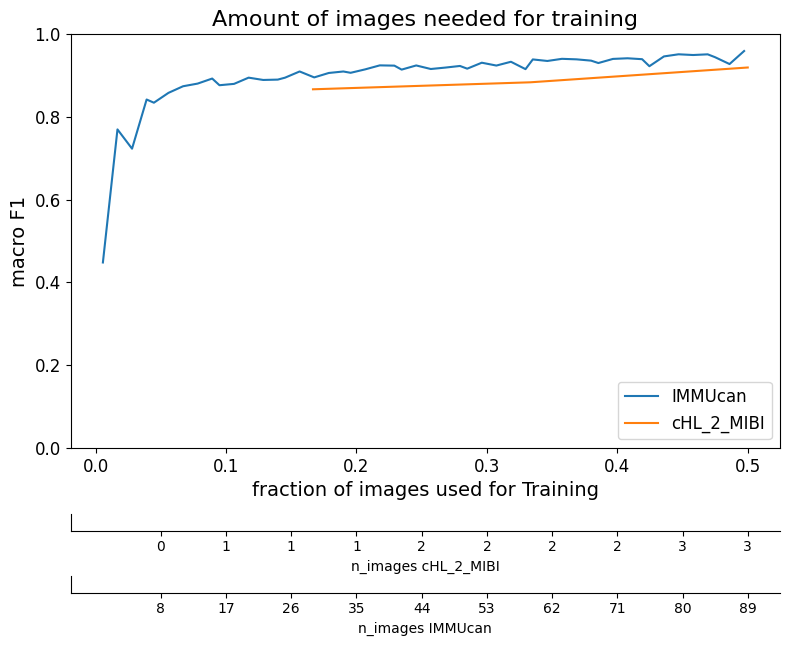

In [44]:
fig, ax1 = plt.subplots(figsize=(8, 7))
sns.lineplot(data=df_score, x='perc_images_IMMUcan', y='f1_score_IMMUcan', ax=ax1, label='IMMUcan')
sns.lineplot(data=df_score, x='perc_images_cHL_2_MIBI', y='f1_score_cHL_2_MIBI', ax=ax1, label='cHL_2_MIBI')
ax1.set_xlabel('fraction of images used for Training', fontsize=14)
ax1.set_ylabel('macro F1', fontsize=14)
plt.ylim(0, 1)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax1.set_title('Amount of images needed for training', fontsize=16)

percent_ticks = np.linspace(0.05, 0.5, num=10)
ax2 = ax1.inset_axes([0, -0.35, 1, 0.04], transform=ax1.transAxes)
immucan_pts = [df_score.iloc[(df_score['perc_images_IMMUcan']-pt).abs().argmin()]['n_images_IMMUcan'] for pt in percent_ticks]
ax2.set_xticks(percent_ticks)
ax2.set_xticklabels([str(int(x)) for x in immucan_pts], fontsize=10)
ax2.set_xlim(ax1.get_xlim())
ax2.set_yticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('n_images IMMUcan')

ax3 = ax1.inset_axes([0, -0.20, 1, 0.04], transform=ax1.transAxes)
cHL_pts = [df_score.iloc[(df_score['perc_images_cHL_2_MIBI']-pt).abs().argmin()]['n_images_cHL_2_MIBI'] for pt in percent_ticks]
ax3.set_xticks(percent_ticks)
ax3.set_xticklabels([str(int(x)) for x in cHL_pts], fontsize=10)
ax3.set_xlim(ax1.get_xlim())
ax3.set_yticks([])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlabel('n_images cHL_2_MIBI')

ax1.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.savefig('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/plots/amount_of_images_needed_for_training.png', dpi=300)
